<a href="https://colab.research.google.com/github/leejielong/yolov1/blob/main/YOLOv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#YOLO Network

Most implementations of YOLO models adapted from the Darknet implementation, where it was originally developed. While pretrained darknet YOLO models can be run in PyTorch, it gives us little control over the architecture. In this notebook we implement YOLOv1 from scratch in PyTorch, trained and validated on the PASCAL VOC 2012 dataset.

In [ ]:
import os
import numpy as np
import tarfile

import torch
import torchvision
from torch import Tensor
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [ ]:
#define grid parameters
S = 8
B = 2
C = 20
img_size = 500
batch_size = 64

###Download Dataset

In [ ]:
dataset_path = '/content/dataset/'
if not os.path.isdir('dataset'):
    print('Downloading PASCAL VOC Dataset...')
    os.mkdir('dataset')
    !gdown https://drive.google.com/u/0/uc?id=1XOm7u2c_CpABfzOYkaFV_5b0KLF9Fmdr -O /content/dataset/VOCtrainval_11-May-2012.tar
    from_path = dataset_path + 'VOCtrainval_11-May-2012.tar'
    to_path = dataset_path
    print(f'Extracting to {dataset_path}...')
    with tarfile.open(from_path, 'r') as tar:
        tar.extractall(to_path)

###Utility Functions

In [ ]:
def corners_to_midpoints(global_corners,S,B):
    """
    Converts global corner coordinate format (xmin,ymin,xmax,ymax)
    to local midpoint coordinate format (y,x,h,w). Returns midpoint
    coordinates relative to interior of cell.

    Args:
        global_corners (Tensor[N,S,S,B*5+C]): Model predictions in global corner format (xmin,ymin,xmax,ymax). 
                                    Elements should be in order of [Pc1,xmin1,ymin1,xmax1,ymax1,Pc2,...,C1,C2,...Cn].
        S (int): Number of rows/columns for S*S cell grid. Grid assumed to be S*S square.
        B (int): Number of bounding boxes per cell

    Returns:
        local_midpoints (Tensor[N,S,S,B*5+C]): Model predictions in local midpoint (yxhw) format.
    """

    global_midpoints = global_corners
    for i in range(B):
        xmin = global_corners[...,0+i*5]
        ymin = global_corners[...,1+i*5]
        xmax = global_corners[...,2+i*5]
        ymax = global_corners[...,3+i*5]

    global_midpoints[...,0+i*5] = torch.add(ymin,ymax).div(2) #y
    global_midpoints[...,1+i*5] = torch.add(xmin,xmax).div(2) #x
    global_midpoints[...,2+i*5] = torch.subtract(ymax,ymin) #h
    global_midpoints[...,3+i*5] = torch.subtract(xmax,xmin) #w

    local_midpoints = global_midpoints
    local_midpoints[...,0+i*5] = torch.div(global_midpoints[...,0+i*5],S).remainder(1) #y
    local_midpoints[...,1+i*5] = torch.div(global_midpoints[...,1+i*5],S).remainder(1) #x                                         
                                                                                    
    return local_midpoints



def midpoints_to_corners(local_midpoints,S,B):
    """
    Converts local midpoint coordinate format (y,x,h,w) to
    global corner coordinate format (xmin,ymin,xmax,ymax). 

    Args:
        local_midpoints (Tensor[...,B*5+C]): Model predictions in local midpoint format (yxhw). 
                                    Elements should be in order of [Pc1,y1,x1,h1,w1,Pc2,...,C1,C2,...Cn].
        S (int): Number of rows/columns for S*S cell grid. Grid assumed to be S*S square.
        B (int): Number of bounding boxes per cell

    Returns:
        corners (Tensor[N,S,S,B*5+C]): Model predictions in global corner format (xmin,ymin,xmax,ymax).
    """

    batch_size = local_midpoints.shape[0]

    #create cell_i matrix to indicate the vertical cell index for each cell
    cell_i_matrix = torch.arange(start=0,end=S).reshape(-1,1).repeat(batch_size,S).reshape(-1,S,S)

    #prepare cell_j matrix to indicate the horizontal cell index for each cell
    cell_j_matrix = torch.arange(start=0,end=S).repeat(1,S*batch_size).reshape(-1,S,S)


    #transform local y,x to global coords for all bboxes in cell
    global_midpoints = local_midpoints
    for i in range(B):
        global_midpoints[...,1+i*5] = torch.add(global_midpoints[...,1+i*5],cell_i_matrix).div(S) #transform y to global
        global_midpoints[...,2+i*5] = torch.add(global_midpoints[...,2+i*5],cell_j_matrix).div(S) #transform x to global

    #convert global midpoints to global corners
    corners = global_midpoints
    for i in range(B):
        y = global_midpoints[...,0+i*5]
        x = global_midpoints[...,1+i*5]
        h = global_midpoints[...,2+i*5]
        w = global_midpoints[...,3+i*5]
        corners[...,0+i*5] = torch.subtract(x,(torch.div(w,2)))#xmin
        corners[...,1+i*5] = torch.subtract(y,(torch.div(h,2)))#ymin
        corners[...,2+i*5] = torch.add(x,(torch.div(w,2)))#xmax
        corners[...,3+i*5] = torch.add(y,(torch.div(h,2)))#ymax      
    
    return corners


### Data Preparation

The PASCAL VOC 2012 dataset provides approximately 10k images, which are split into train and validation sets in a 50:50 ratio. These images come in different dimensions, so we have to pad them to the same input shape of 500x500 before we create the dataloader.

Also, the annotations are stored in a nested dictionary, so we extract the relevant fields and pad the object lists so that the targets are of the same shape as well.

In our labels and predictions, we rely on a matrix shape of [N,S,S,B*5+C], where N refers to the number of examples, S refers to the grid size, B refers to the number of bounding boxes per cell, and C refers to the number of predicted classes.

If there are more than B objects in a cell, we will select the object with the largest area (we assume larger objects are more important).Nevertheless, if we increase S, the probability of having more than B real objects in a cell is low.



In [ ]:
#prepare label matrix

class_map = {
    0 : 'person',
    1 : 'bird',
    2 : 'cat',
    3 : 'cow',
    4 : 'dog',
    5 : 'horse',
    6 : 'sheep',
    7 : 'aeroplane',
    8 : 'bicycle',
    9 : 'boat',
    10 : 'bus',
    11 : 'car',
    12 : 'motorbike',
    13 : 'train',
    14 : 'bottle',
    15 : 'chair',
    16 : 'diningtable',
    17 : 'pottedplant',
    18 : 'sofa',
    19 : 'tvmonitor'
}

inv_class_map = {v: k for k, v in class_map.items()}

class ToLabelMatrix():
    """
    Converts VOC object annotations to target tensors

    Args: 
        S (int): Cell count. Image will be divided into S*S cells
        B (int): Anchor Boxes. Number of anchor boxes per cell
        C (int): Number of object classes
        img_size (int): size of image (assume square image of dimensions img_size * img_size)
        inv_class_map (dict{str:int}): map of class name to class number 

    Returns:
        label_matrix (Tensor): Label matrix of shape [N,S,S,5+C] in global corner coords format
    """
    def __init__(self,S,B,C,img_size,inv_class_map):
        assert isinstance(S, int)
        assert isinstance(B, int)
        assert isinstance(C, int)
        assert isinstance(img_size, int)

        self.S = S
        self.B = B
        self.C = C
        self.img_size = img_size
        self.inv_class_map = inv_class_map
    
    def __call__(self, sample):
        objects = sample['annotation']['object'] #each image contains multiple objects

        #we place the objects in a single label matrix for each image.
        #if there is more than one object in the same cell, we select the image with the
        #larger bounding box area

        label_matrix = torch.zeros(self.S,self.S,5+self.C) 

        for idx, obj in enumerate(objects):
            # print(idx,obj)

            xmin,ymin,xmax,ymax,i,j,obj_num,area = self._compute_obj_properties(obj)

            if area > label_matrix[i,j,3] * label_matrix[i,j,4]: #insert object if its area is larger then current object in cell
                label_matrix[i,j,0:5] = torch.tensor([1,xmin,ymin,xmax,ymax])
                label_matrix[i,j,5+obj_num] = 1 #assign flag to object class

        # print(label_matrix.shape) #global corners format
        # print(label_matrix[...,0])
        return label_matrix 

    
    def _compute_obj_properties(self, obj):
        """
        Calculates essential properties of object label. 

        Args:
            obj (list): list contain dicts for each object

        Returns:
            xmin (float): scaled minimum x coordinate of box
            ymin (float): scaled minimum y coordinate of box
            xmax (float): scaled maximum x coordinate of box
            ymax (float): scaled maximum y coordinate of box
            i (int): cell number of object along y axis
            j (int): cell number of object along x axis
            obj_num (int): class of object
            area (float): area of bounding box
        """
        obj_name = obj['name']
        obj_num = self.inv_class_map[obj_name]

        xmin = float(obj['bndbox']['xmin'])/self.img_size
        ymin = float(obj['bndbox']['ymin'])/self.img_size
        xmax = float(obj['bndbox']['xmax'])/self.img_size
        ymax = float(obj['bndbox']['ymax'])/self.img_size

        #get object cell indexes
        i = int(0.5*(ymax + ymin)*self.S)
        j = int(0.5*(xmax + xmin)*self.S)

        area = (xmax-xmin)*(ymax-ymin)

        return xmin,ymin,xmax,ymax,i,j,obj_num,area


#create a custom transform that pads the images to the same dimensions
class Pad():
    """
    Pads the image to a given size

    Args: 
        output_size (int): Desired output size. Image is padded for height
        and width to be equal to output size.
    """
    def __init__(self,output_size):
        assert isinstance(output_size, int) #make sure output_size is an int
        self.output_size = output_size
    
    def __call__(self, sample):
        output = torch.nn.functional.pad(sample, (0,self.output_size-sample.shape[-1],0,self.output_size-sample.shape[-2]))
        return output

#instantiate data and label transformers
transform = transforms.Compose([ToTensor(),Pad(img_size)])
target_transform = ToLabelMatrix(S=S,B=B,C=C,img_size=img_size,inv_class_map=inv_class_map)


In [ ]:
train_data = datasets.VOCDetection(root=dataset_path,
                                   year="2012",
                                   image_set="train",
                                   download=False,
                                   transform=transform,
                                   target_transform=target_transform
                                   )

val_data = datasets.VOCDetection(root=dataset_path,
                                 year="2012",
                                 image_set="val",
                                 download=False,
                                 transform=transform,
                                 target_transform=target_transform
                                 )

In [ ]:
print(train_data[0][0].shape)

Let's visualise some samples from the training dataset

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

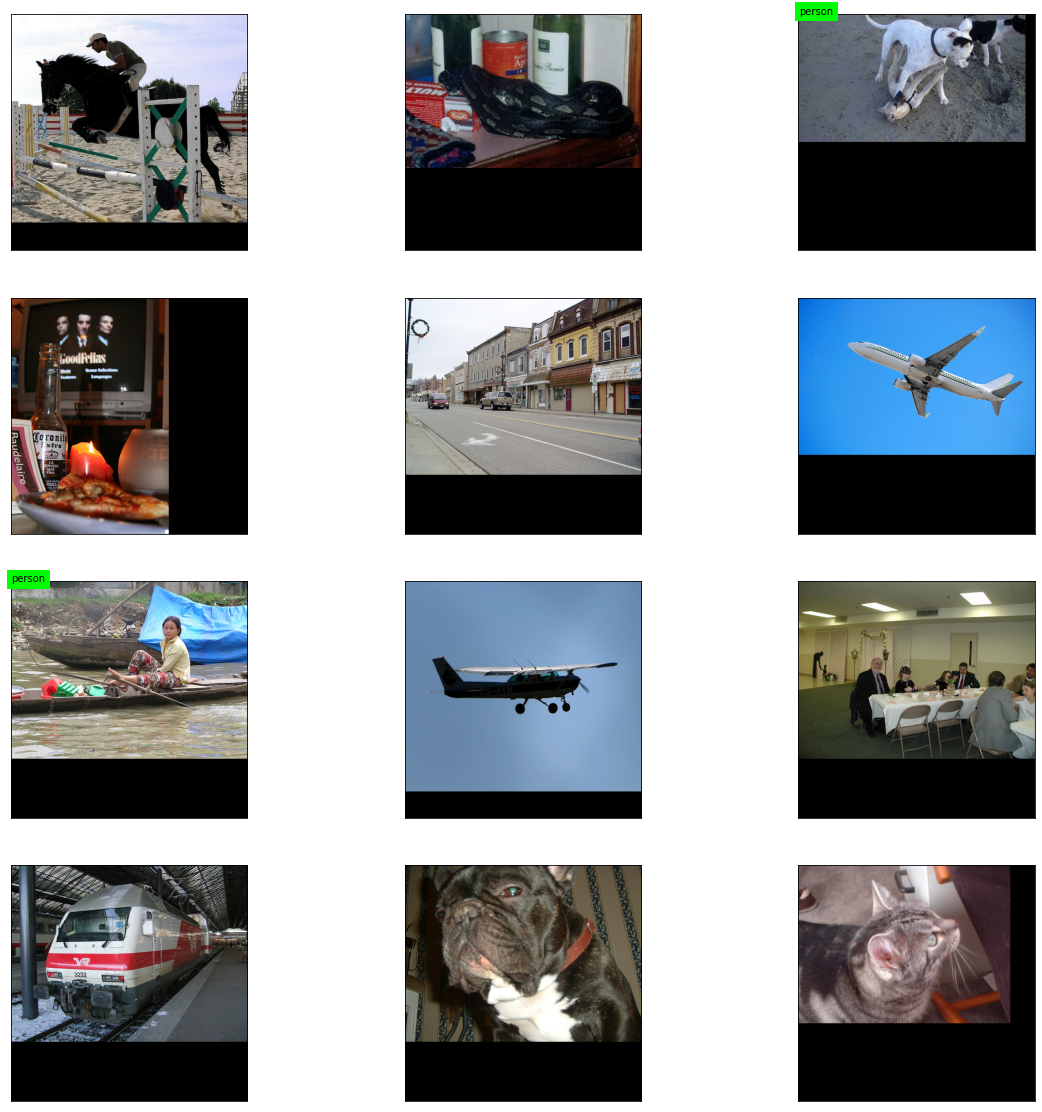

In [24]:
# def plot_samples(num_plots, data):
#     plt.figure(figsize = (20,20))
#     plt.tight_layout()


#     for i in range(num_plots):
#         image = data[i][0].numpy()
#         image = np.transpose(image,(1,2,0))

#         #process labels
#         label_matrix = data[i][1]
#         print(label_matrix)

#         ax = plt.subplot(num_plots/3,3,i+1)
#         plt.xticks([])
#         plt.yticks([])
#         plt.imshow(image)

#         for j in range(S):
#             for k in range(S):
#                 if label_matrix[0,j,k] == 1: # object is present
#                     [xmin,ymin,xmax,ymax] = label_matrix[1:5,j,k]*img_size #extract xyxy
#                     print(xmin,ymin,xmax,ymax)
                    

#                     #draw rectangle
#                     w = xmax-xmin
#                     h = ymax-ymin

#                     ax.add_patch(
#                         Rectangle((xmin,ymin),
#                                   w,
#                                   h,
#                                   fill=False,
#                                   edgecolor='lime',
#                                   lw=2)
#                     )

#                     #get class name
#                     class_vec = label_matrix[-20:,j,k]
#                     obj_num = torch.argmax(class_vec)
#                     obj_name = class_map[obj_num.item()]
#                     ax.text(xmin,xmin, s=obj_name, backgroundcolor='lime') #obj_name 
        
#     return

# plot_samples(12,train_data)

In [10]:
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))

In [11]:
train_features, train_labels = next(iter(train_dataloader))

In [12]:
print(train_features.shape)
print(train_labels.shape)

torch.Size([64, 3, 500, 500])
torch.Size([64, 8, 8, 25])


#Construct Model

Now that we have prepared the inputs and labels, we can start constructing the model.

![picture](https://www.researchgate.net/publication/329038564/figure/fig2/AS:694681084112900@1542636285619/YOLO-architecture-YOLO-architecture-is-inspired-by-GooLeNet-model-for-image.ppm)

The vanilla YOLOv1 uses a DarkNet architecture, however in this implementation, we switch to a pretrained ResNet50 backbone. The backbone can be swapped out as required.

In [13]:
class YoloNet(nn.Module):
    """
    Initializes a YOLOv1 network with a ResNet-50 backbone

    """
    def __init__(self,S,B,C):
        self.S = S
        self.B = B
        self.C = C
        super(YoloNet,self).__init__()
        resnet50_full = torchvision.models.resnet50(pretrained=True)
        resnet50_layers = list(resnet50_full.children())
        selected_layers = resnet50_layers[:-2]
        resnet50_selected = nn.Sequential(*selected_layers)
        self.resnet50 = resnet50_selected
        self.trainable_conv = self._create_trainable_conv()
        self.fcs = self._create_fcs()


    def forward(self,x):
        with torch.no_grad():
            x = self.resnet50(x) #freeze pretrained resnet
        x = self.trainable_conv(x)
        x = self.fcs(x)
        x = x.reshape(-1,self.S,self.S,self.B*5+self.C)
        return x

    def _create_fcs(self):
        return nn.Sequential(
            nn.Flatten(), #flatten conv output before linking to fc
            nn.Linear(1024*self.S*self.S, 512), #while the paper uses 4096 nodes, we restrict to 512 nodes to reduce model size
            nn.Dropout(0.5),
            nn.LeakyReLU(0.1),
            nn.Linear(512, self.S*self.S*(self.B*5+self.C)), #we first create a linear layer, to be reshaped to (8,8,30) during loss computation
            nn.Sigmoid() #bounds outputs between 0 and 1
        )
    
    def _create_trainable_conv(self):
        return nn.Sequential(
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(2048,1024, kernel_size=(3,3), stride=(2,2), padding=(1,1), bias=False), #ResNet produces 2048,16,16 output. We downscale the output to 2048,8,8 to match S
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(1024,1024, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(1024,1024, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False),
            nn.LeakyReLU(negative_slope=0.1)
        )

#Non-Maximal Suppression

![picture](https://drek4537l1klr.cloudfront.net/elgendy/v-8/Figures/07_img_0028.png)

During inference, object detection models tend to propose several bounding boxes for each object, since neighbouring cells observe similar image regions. Ideally, we would expect to attain a single proposed bounding box per real object. Non-Max Suppression is a technique commonly used during inference to distil object proposals, leaving only high confidence proposals to be presented.

The intuition behind non max suppression is that an object detector is likely to propose clusters of bounding boxes around real object. By applying NMS, we select the bounding box with the highest confidence Pc, and remove/suppress other non-maximum proposals within a vicinity around the selected box. We use IoU to measure the overlap of neigbouring proposals against the selected box, to help us identify neighbouring boxes for removal.

NMS in PyTorch: 
PyTorch's NMS function executes NMS on the bounding boxes of a single class for a single image. To cater for efficient NMS on multiclass prediction, we need to perform batched multiclass NMS, where we apply NMS in parallel on groups of bounding boxes categorized by their batch position and predicted class. Assuming a prediction of shape (N, C, S, S) with K unique classes detected, there needs to be N*K groups which we will apply NMS on.

While Tensorflow provides a batched multiclass nms function, PyTorch provides only a batched_nms() function. Groups are identified based on an index value. As such, we will need to encode both batch position and predicted class to obtain these groupings. 

Batch size can vary from 1 to infinity, so it can take a number of digits. Class categories range from 1 to 20.

We can simply take batch position *100 + class number. So for position 1 and class 1, we will get 101. This will give us uniquely assigned categories.

We will create a function to perform batched multiclass NMS.

Note: 

Network -> NMS -> Loss
NMS is treated as the last layer for the network.

As a network produces outputs of shape [N,B*5+C,S,S], NMS should return a tensor of the same shape, just that non-maximal bounding boxes have their Pc set to 0. 

Next we compute the multipart loss. We compute the detection error first, accumulating the noobjs. 

In [14]:
def test():
    data, label = next(iter(train_dataloader))
    network = YoloNet(S,B,C)
    network.eval()
    output = network(data)
    # print(output.shape)
    # print(output[...,0])
    return output, label

In [15]:
#transform the [N,8,8,30] prediction to a suitable form for batched_multiclass_nms
def batched_multiclass_nms(preds: Tensor,B: int,C: int,S: int, pc_threshold: float, iou_threshold: float) -> Tensor:
    """
        Performs batched multiclass Non-Maximal Suppression (NMS) on input tensors of shape [N,S,S,B*5+C].

        Args:
            preds (Tensor[N,S,S,B*5+C]): Predictions of object detection model in local midpoint coords format
            B (int): Number of bounding boxes per cell
            C (int): Number of object classes
            S (int): Number of rows/columns for S*S cell grid. Grid assumed to be S*S square.
            pc_threshold (int): Minimum confidence required for bounding box to qualify for NMS. 
                                Automatically suppressed if confidence is below pc_threshold. 
            iou_threshold (int): Extent of IoU overlap required for neighbouring box to be suppressed

        Returns:
            preds_nms (Tensor[N,S,S,B*5+C]): Post-NMS predictions from object detection model in local midpoint coords format
    """
    # with torch.no_grad(): #freeze all layers

    #prepare batch matrix to indicate batch position for each cell
    batch_size = preds.shape[0]
    batch_matrix = torch.arange(start=0,end=batch_size).reshape(-1,1).repeat(1,S*S).reshape(-1,S,S,1)

    #prepare class matrix to indicate predicted class for each cell
    class_matrix = preds[...,B*5:].argmax(-1).reshape(-1,S,S,1)

    #prepare cell_i matrix to indicate the vertical cell index for each cell
    cell_i_matrix = torch.arange(start=0,end=S).reshape(-1,1).repeat(batch_size,S).reshape(-1,S,S,1)

    #prepare cell_j matrix to indicate the horizontal cell index for each cell
    cell_j_matrix = torch.arange(start=0,end=S).repeat(1,S*batch_size).reshape(-1,S,S,1)

    #convert coordinates in preds from local midpoint format to global corner format
    corner_preds = midpoints_to_corners(preds.clone(),S,B)
    
    #seperate the bounding boxes for each cell into its independent box, and append the auxiliary info derived above
    #form a full list of unique bounding boxes [N,10]
    for i in range(B): 
        box_preds = corner_preds[...,i*5:(i+1)*5] #coord elements in xyxy format
        box_preds = torch.cat((box_preds, batch_matrix),dim=-1) #add batch position number to bbox
        box_preds = torch.cat((box_preds, class_matrix),dim=-1) #add class number to bbox
        box_preds = torch.cat((box_preds, cell_i_matrix),dim=-1)#add cell i position to bbox
        box_preds = torch.cat((box_preds, cell_j_matrix),dim=-1)#add cell j position to bbox
        box_idx = torch.ones([batch_size,S,S,1])*i
        box_preds = torch.cat((box_preds, box_idx),dim=-1)#add bbox position to bbox
        box_preds = box_preds.reshape(-1,10)

        if i == 0: #first iteration
            bboxes = box_preds
        else: 
            bboxes = torch.cat((bboxes,box_preds), dim=0)

    #drop bboxes below pc threshold
    bboxes_mask = bboxes[:,0]>pc_threshold
    bboxes_mask = bboxes_mask.reshape(-1,1)
    filtered_bboxes = torch.masked_select(bboxes,bboxes_mask).reshape(-1,10)

    #extract bbox components
    scores = filtered_bboxes[...,0]
    boxes = filtered_bboxes[...,1:5]
    batch_idxs = filtered_bboxes[...,5]
    class_idxs = filtered_bboxes[...,6]
    cell_i_idxs = filtered_bboxes[...,7]
    cell_j_idxs = filtered_bboxes[...,8]
    bbox_idxs = filtered_bboxes[...,9]


    #create unique batch-class categories
    idx = torch.add(torch.mul(batch_idxs,100),class_idxs) 

    #perform batched multiclass nms
    selected_bboxes = torchvision.ops.batched_nms(boxes=boxes, scores=scores,idxs=idx,iou_threshold=iou_threshold)

    #Pick out bboxes identified in nms list. First we create a full matrix and zero out all Pcs. 
    #Then re-insert the Pcs of the selected bboxes into their respective locations
    preds_nms = preds.clone() #local midpoint format


    for i in range(B):
        preds_nms[...,i*5] = 0 #zero out all Pcs

    for box_id in selected_bboxes:
        box_score = scores[box_id] #score of selected box
        box_batch = int(batch_idxs[box_id].item())
        box_class = int(class_idxs[box_id].item())
        box_i = int(cell_i_idxs[box_id].item())
        box_j = int(cell_j_idxs[box_id].item())
        box_bbox = int(bbox_idxs[box_id].item())
        # print(box_score, box_batch,box_class,box_i,box_j,box_bbox)

        preds_nms[box_batch,box_i,box_j,box_bbox*5] = box_score
        
    # print(preds_nms[...,0])
    return preds_nms

# ### Test cases for batched_multiclass_nms implementation
# preds = torch.zeros([4,8,8,30])
# #create one box in batch 0, cell 0-0, x=0,y=0, w=0.5,h=0.5, class 5, pc=0.8, bbox 0
# preds[0,0,0,:] = torch.tensor([0.8,0.2,0,0.5,0.5,
#                                0,0,0,0,0,
#                                0,0,0,0,1,0,0,0,0,0,
#                                0,0,0,0,0,0,0,0,0,0,
#                                ])
# #create one box in batch 1, cell 0-0, x=0,y=0, w=0.5,h=0.5, class 5, pc=0.8, bbox 1
# preds[1,0,0,:] = torch.tensor([0,0,0,0,0,
#                                0.8,0.3,0,0.5,0.5,
#                                0,0,0,0,1,0,0,0,0,0,
#                                0,0,0,0,0,0,0,0,0,0,
#                                ]) 
# #create one box in batch 0, cell 1-1, x=0,y=0, w=0.5,h=0.5, class 5, pc=0.7, bbox 0 - should be suppressed
# preds[0,1,1,:] = torch.tensor([0.7,0.4,0,0.5,0.5,
#                                0,0,0,0,0,
#                                0,0,0,0,1,0,0,0,0,0,
#                                0,0,0,0,0,0,0,0,0,0,
#                                ])

# #create one box in batch 2, cell 0-0, x=0,y=0, w=0.5,h=0.5, class 5, pc=0.019, bbox 0 - should be suppressed
# preds[2,0,0,:] = torch.tensor([0.02,0,0,0.5,0.5,
#                                0,0,0,0,0,
#                                0,0,0,0,1,0,0,0,0,0,
#                                0,0,0,0,0,0,0,0,0,0,
#                                ])

# # preds = test()
# preds = batched_multiclass_nms(preds,B,C,S,pc_threshold=0.02,iou_threshold=0.5)

#test on real predictions
# preds, labels = test()
# output = batched_multiclass_nms(preds,B,C,S,pc_threshold=0.5,iou_threshold=0.5)


#Construct Loss Function
The YOLO multi-part loss function is described in the paper as follows: 

![picture](https://miro.medium.com/max/1018/1*smK6Jqarqw09nA7vnQexAg.png)

There are three key components in this loss:
* Localization Error
    * Squared error of predicted center coordinates (x,y)
    * Squared error of predicted width/height (w,h). Square roots are applied to w,h to reduce the disproportionate effect of small differences in large bounding boxes 
    * A Lambda Coord parameter is used to increase significance of localisation error
* Detection Error
    * Squared error of boxes with real objects
    * Squared error of boxes with no objects (Scaled by Lambda Noobj parameter to reduce effect of class imbalance, since most cells do not contain objects)
* Classification Error
    * Sum Squared error of class vector for cells containing real objects


Before we can construct the multi-part loss function, we need a function to calculate IoU. This is needed as the predicted bounding box with the highest IoU to the ground truth will be used to calculate the localization and detection losses.

Our multi-part loss function can be approached with the following sequence.

For a given image and its corresponding label matrix,
iterate over all label cells in label matrix:
1. For label cells with no object, calculate negative detection error across all boxes in the cell. We can invert label_matrix[...,0] to obtain a selection mask, then use masked_select to get the non-object Pcs at pos 0 and 5 of each cell. We can concatenate the extracted Pcs from both bbox positions, then compute the sum of squares for the first portion of noobj loss. 
2. For label cells containing objects: 
    1. calculate classification error. We can use label_matrix[...,0] (with torch.repeat) as a mask to select cells with real objects. We take the sum of squared difference to get the classification loss
    2. calculate IoUs against the bounding boxes in the corresponding prediction cell. Use label_matrix[...,0] to select the cells with real objects, 
    3. For the highest IoU box: 
        1. calculate positive detection error
        2. calculate localization error between the label box and prediction box.
    4. For remaining boxes, calculate negative detection error for the remaining bounding boxes in the prediction cell. 




In [16]:
def yolo_loss(preds,labels, S,B,C): 
    """
    Computes multipart loss for YOLOv1 algorithm.

    Args:
        preds (Tensor[N,S,S,B*5+C]): Predictions of object detection model in local midpoint coords format
        labels (Tensor): Label matrix of shape [N,S,S,5+C] in global corner coords format
        S (int): Number of rows/columns for S*S cell grid. Grid assumed to be S*S square.
        B (int): Number of bounding boxes per cell
        C (int): Number of classes

    Returns:
        loss (Tensor): Summed multipart loss
    """
    
    ### Part 1: No Object Loss
    noobj_loss = torch.tensor(0.0)
    for i in range(B):
        bbox_pc = preds[...,i*5] #(4,8,8)
        bbox_pc = bbox_pc.reshape(-1,1) #(256,1)
        bbox_loss = bbox_pc ** 2
        bbox_loss = torch.sum(bbox_loss)
        noobj_loss = noobj_loss + bbox_loss

    ### Part 2: Object Loss

    #convert local midpoint preds to global corner format
    global_corner_preds = midpoints_to_corners(preds.clone().detach(),S,B) 

    #create object mask
    obj_mask = labels[...,0].type(torch.bool).unsqueeze(-1) #get Pc of labels to select object cells (4,8,8,1)

    #extract object preds
    obj_preds_global = torch.masked_select(global_corner_preds,obj_mask).reshape(-1,B*5+C) #shape [N,30] global corner version
    obj_preds_local = torch.masked_select(preds,obj_mask).reshape(-1,B*5+C) #shape [N,30] local midpoint version

    #extract object labels
    obj_labels_global = torch.masked_select(labels,obj_mask).reshape(-1,5+C) #shape [N,25], labels in global corner format
    obj_labels_local = torch.masked_select(corners_to_midpoints(labels.clone().detach(),S,1),obj_mask).reshape(-1,5+C) #labels in local midpoint format

    #extract object bboxes
    for i in range(B):
        if i==0:
            obj_bboxes = obj_preds_global[...,i*5+1:i*5+5] #shape [N,4]
        else:
            obj_bboxes = torch.cat((obj_bboxes,obj_preds_global[...,i*5+1:i*5+5]),dim=-1) #shape [N,4]
    
    stacked_obj_bboxes = obj_bboxes.reshape(-1,B,4) #bboxes in same cell are stacked in shape (N,B,4), in global corner format

    #compute ious and select best bboxes. output shape = [N,25]
    selected_bboxes = torch.zeros_like(obj_labels_global)
    for idx, obj_bboxes in enumerate(stacked_obj_bboxes):
        obj_label = obj_labels_global[idx,1:5].reshape(-1,4)
        box_ious = torchvision.ops.box_iou(obj_label,obj_bboxes)
        bestbox_idx = torch.argmax(box_ious,dim=-1).item()

        selected_bboxes[idx,0:5] = obj_preds_local[idx,bestbox_idx*5:bestbox_idx*5+5] #save selected bbox in local midpoint format
        selected_bboxes[idx,-C:] = obj_preds_local[idx,-C:] #save class predictions

    #compensate noobj_loss
    noobj_loss_compensate = torch.sum(selected_bboxes[...,0] ** 2).item()
    noobj_loss = noobj_loss - noobj_loss_compensate #account for selected boxes added to noobj_loss earlier
    print(f"noobj loss: {noobj_loss}") #to deduct object loss later


    #compute obj_loss
    obj_loss = torch.sum((1-selected_bboxes[...,0])**2)
    print(f"object loss: {obj_loss}")

    ### Part 3: Classification Loss
    selected_bboxes_classes = selected_bboxes[...,-C:]
    obj_labels_classes = obj_labels_global[...,-C:]
    classification_loss = torch.sum((obj_labels_global - selected_bboxes) ** 2)

    print(f"classification loss: {classification_loss}")

    ### Part 4: Localization Loss

    # y loss
    selected_bboxes_y = selected_bboxes[...,1]
    obj_labels_y = obj_labels_local[...,1]
    localization_loss_y = torch.sum((obj_labels_y-selected_bboxes_y)**2)

    #x loss
    selected_bboxes_x = selected_bboxes[...,1]
    obj_labels_x = obj_labels_local[...,1]
    localization_loss_x = torch.sum((obj_labels_x-selected_bboxes_x)**2)

    #h loss
    selected_bboxes_h = selected_bboxes[...,1]
    obj_labels_h = obj_labels_local[...,1]
    localization_loss_h = torch.sum(((obj_labels_h ** 0.5)-(selected_bboxes_h ** 0.5))**2)

    #w loss
    selected_bboxes_w = selected_bboxes[...,1]
    obj_labels_w = obj_labels_local[...,1]
    localization_loss_w = torch.sum(((obj_labels_w ** 0.5)-(selected_bboxes_w ** 0.5))**2)

    localization_loss = localization_loss_y + localization_loss_x + localization_loss_h + localization_loss_w
    print(f"localization loss: {localization_loss}")

    total_loss = noobj_loss + obj_loss + classification_loss + localization_loss

    print(f"total loss: {total_loss}")
    print(total_loss)
    return total_loss

# preds, labels = test()
# preds = batched_multiclass_nms(preds,B,C,S,pc_threshold=0.5,iou_threshold=0.5)
# loss = yolo_loss(preds,labels,S,B,C)
# loss.backward() #computes gradients and stores them for optimizer

In [17]:
def train(epochs,S,B,C):
    network = YoloNet(S,B,C)
    network.train()
    optimizer = optim.SGD(network.parameters(),lr=0.001,momentum=0.9,weight_decay=0.0005)

    for batch_idx, (data,labels) in enumerate(train_dataloader):
        optimizer.zero_grad() #reset gradients for each step
        preds = network(data)
        loss = yolo_loss(preds,labels,S,B,C)
        loss.backward()
        optimizer.step()
        break

epochs = 1
train(epochs,S,B,C)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth



CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 6.2 µs


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


noobj loss: 2009.5069580078125
object loss: 37.16653060913086
classification loss: 833.195556640625
localization loss: 138.4060821533203
total loss: 3018.275146484375
tensor(3018.2751, grad_fn=<AddBackward0>)


In [18]:
class YoloLoss(nn.Module):
    def __init__(self, S=8, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.S = S
        self.B = B
        self.C = C
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, preds, labels):
        S = self.S
        B = self.B
        C = self.C

        ### Part 1: No Object Loss
        noobj_loss = 0
        for i in range(B):
            bbox_pc = preds[...,i*5] #(4,8,8)
            bbox_pc = bbox_pc.reshape(-1,1) #(256,1)
            bbox_loss = bbox_pc ** 2
            bbox_loss = torch.sum(bbox_loss).item()
            noobj_loss += bbox_loss
        
        
        print(f"noobj loss: {noobj_loss}") #to deduct object loss later

        ### Part 2: Object Loss

        #convert local midpoint preds to global corner format
        global_corner_preds = midpoints_to_corners(preds.clone().detach(),S,B) 

        #create object mask
        obj_mask = labels[...,0].type(torch.bool).unsqueeze(-1) #get Pc of labels to select object cells (4,8,8,1)

        #extract object preds
        obj_preds_global = torch.masked_select(global_corner_preds,obj_mask).reshape(-1,B*5+C) #shape [N,30] global corner version
        obj_preds_local = torch.masked_select(preds,obj_mask).reshape(-1,B*5+C) #shape [N,30] local midpoint version

        #extract object labels
        obj_labels_global = torch.masked_select(labels,obj_mask).reshape(-1,5+C) #shape [N,25], labels in global corner format
        obj_labels_local = torch.masked_select(corners_to_midpoints(labels.clone().detach(),S,1),obj_mask).reshape(-1,5+C) #labels in local midpoint format

        #extract object bboxes
        for i in range(B):
            if i==0:
                obj_bboxes = obj_preds_global[...,i*5+1:i*5+5] #shape [N,4]
            else:
                obj_bboxes = torch.cat((obj_bboxes,obj_preds_global[...,i*5+1:i*5+5]),dim=-1) #shape [N,4]
        
        stacked_obj_bboxes = obj_bboxes.reshape(-1,B,4) #bboxes in same cell are stacked in shape (N,B,4), in global corner format

        #compute ious and select best bboxes. output shape = [N,25]
        selected_bboxes = torch.zeros_like(obj_labels_global)
        for idx, obj_bboxes in enumerate(stacked_obj_bboxes):
            obj_label = obj_labels_global[idx,1:5].reshape(-1,4)
            box_ious = torchvision.ops.box_iou(obj_label,obj_bboxes)
            bestbox_idx = torch.argmax(box_ious,dim=-1).item()

            selected_bboxes[idx,0:5] = obj_preds_local[idx,bestbox_idx*5:bestbox_idx*5+5] #save selected bbox in local midpoint format
            selected_bboxes[idx,-C:] = obj_preds_local[idx,-C:] #save class predictions

        #compensate noobj_loss
        noobj_loss_compensate = torch.sum(selected_bboxes[...,0] ** 2)
        noobj_loss -= noobj_loss_compensate #account for selected boxes added to noobj_loss earlier

        #compute obj_loss
        obj_loss = torch.sum((1-selected_bboxes[...,0])**2)

        print(f"object loss: {obj_loss}")

        ### Part 3: Classification Loss
        selected_bboxes_classes = selected_bboxes[...,-C:]
        obj_labels_classes = obj_labels_global[...,-C:]
        classification_loss = torch.sum((obj_labels_global - selected_bboxes) ** 2)
        print(f"classification loss: {classification_loss}")

        ### Part 4: Localization Loss

        # y loss
        selected_bboxes_y = selected_bboxes[...,1]
        obj_labels_y = obj_labels_local[...,1]
        localization_loss_y = torch.sum((obj_labels_y-selected_bboxes_y)**2)

        #x loss
        selected_bboxes_x = selected_bboxes[...,1]
        obj_labels_x = obj_labels_local[...,1]
        localization_loss_x = torch.sum((obj_labels_x-selected_bboxes_x)**2)

        #h loss
        selected_bboxes_h = selected_bboxes[...,1]
        obj_labels_h = obj_labels_local[...,1]
        localization_loss_h = torch.sum(((obj_labels_h ** 0.5)-(selected_bboxes_h ** 0.5))**2)

        #w loss
        selected_bboxes_w = selected_bboxes[...,1]
        obj_labels_w = obj_labels_local[...,1]
        localization_loss_w = torch.sum(((obj_labels_w ** 0.5)-(selected_bboxes_w ** 0.5))**2)

        localization_loss = localization_loss_y + localization_loss_x + localization_loss_h + localization_loss_w

        print(f"localization loss: {localization_loss}")

        total_loss = self.lambda_noobj*noobj_loss + obj_loss + classification_loss + self.lambda_coord*localization_loss

        print(f"total loss: {total_loss}")
        return total_loss

yololoss = YoloLoss(S=S,B=B,C=C)
test = yololoss(preds,labels)



NameError: ignored

In [ ]:
def my_loss(output, target):
    loss = torch.mean((output - target)**2)
    return loss

model = nn.Linear(2, 2)
x = torch.randn(1, 2)
target = torch.randn(1, 2)
output = model(x)
loss = my_loss(output, target) #can do anything as long as the output is a tensor.
print(loss)
# loss.backward() #backward call is for a tensor object
# print(model.weight.grad)